In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [208]:
class DoublePendulum:
    def __init__(
        self,
        y0: np.ndarray,
        g: float,
        m1: float,
        m2: float,
        l1: float,
        l2: float,
        dt: float,
        N_steps: int,
    ):
        self.y0 = y0
        self.g = g
        self.m1 = m1
        self.m2 = m2
        self.l1 = l1
        self.l2 = l2
        self.dt = dt
        self.N_steps = N_steps

    def right_hand_side(
        self,
        t: float,
        y: np.ndarray,
    ) -> np.ndarray:
        th1, th2, om1, om2 = y
        g, l1, l2, m1, m2 = self.g, self.l1, self.l2, self.m1, self.m2
        dydt = [
            om1,
            om2,
            (
                -g * (2 * m1 + m2) * np.sin(th1)
                - m2 * g * np.sin(th1 - 2 * th2)
                - 2
                * np.sin(th1 - th2)
                * m2
                * (om2**2 * l2 + om1**2 * l1 * np.cos(th1 - th2))
            )
            / (l1 * (2 * m1 + m2 - m2 * np.cos(2 * th1 - 2 * th2))),
            (
                2
                * np.sin(th1 - th2)
                * (
                    om1**2 * l1 * (m1 + m2)
                    + g * (m1 + m2) * np.cos(th1)
                    + om2**2 * l2 * m2 * np.cos(th1 - th2)
                )
            )
            / (l2 * (2 * m1 + m2 - m2 * np.cos(2 * th1 - 2 * th2))),
        ]
        return np.array(dydt)

    def simulate(self) -> tuple[np.ndarray, np.ndarray]:
        t_span = (0, self.dt * self.N_steps)
        t_eval = np.linspace(*t_span, self.N_steps)
        sol = solve_ivp(
            self.right_hand_side,
            t_span,
            self.y0,
            t_eval=t_eval,
        )
        return sol.t, sol.y

    def to_euclidean(self, y_traj: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        ball1 = [
            [self.l1 * np.sin(theta1) for theta1 in y_traj[0]],
            [-self.l1 * np.cos(theta1) for theta1 in y_traj[0]],
        ]
        ball2 = [
            [
                self.l1 * np.sin(theta1) + self.l2 * np.sin(theta2)
                for theta1, theta2 in zip(y_traj[0], y_traj[1])
            ],
            [
                -self.l1 * np.cos(theta1) - self.l2 * np.cos(theta2)
                for theta1, theta2 in zip(y_traj[0], y_traj[1])
            ],
        ]
        return np.array(ball1), np.array(ball2)

    def rk45_step(self, t: float, y: np.ndarray) -> np.ndarray:
        k1 = self.right_hand_side(t, y)
        k2 = self.right_hand_side(t + self.dt / 2, y + self.dt / 2 * k1)
        k3 = self.right_hand_side(t + self.dt / 2, y + self.dt / 2 * k2)
        k4 = self.right_hand_side(t + self.dt, y + self.dt * k3)
        return y + self.dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

    def animate(self, t_vals: np.ndarray, y_traj: np.ndarray, name: str) -> None:
        from matplotlib.animation import FuncAnimation
        ball1, ball2 = self.to_euclidean(y_traj)

        _S = 5
        ball1 = ball1[:, ::_S]
        ball2 = ball2[:, ::_S]
        t_vals = t_vals[::_S]

        LIMS = (-2, 2)
        fig, ax = plt.subplots()
        ax.set_xlim(*LIMS)
        ax.set_ylim(*LIMS)
        ax.set_aspect(1)
        ax.grid()
        (line1,) = ax.plot([], [], ".-")
        (line2,) = ax.plot([], [], ".-")
        (trace,) = ax.plot([], [], ":")


        def anim_frame(i):
            line1.set_xdata([0, ball1[0][i]])
            line1.set_ydata([0, ball1[1][i]])
            line2.set_xdata([ball1[0][i], ball2[0][i]])
            line2.set_ydata([ball1[1][i], ball2[1][i]])
            trace.set_xdata(ball2[0][:i])
            trace.set_ydata(ball2[1][:i])

            ax.set_title(f"t = {t_vals[i]:.2f} sec")
            ax.set_xlabel("x, m")
            ax.set_ylabel("y, m")
            ax.set_aspect(1)
            return line1, line2, trace


        animation = FuncAnimation(
            fig, func=anim_frame, frames=list(range(len(t_vals))), blit=True
        )

        animation.save(name, fps=30)
        return None

In [209]:
sim = DoublePendulum(
    y0=np.array([np.pi / 2, np.pi, 0.0, 0.0]),
    g=9.81,
    m1=1,
    m2=1,
    l1=1,
    l2=1,
    dt=0.005,
    N_steps=10000,
)

In [210]:
res = sim.simulate()
t_vals, y_traj_pol = res

In [211]:
ball1, ball2 = sim.to_euclidean(y_traj_pol)

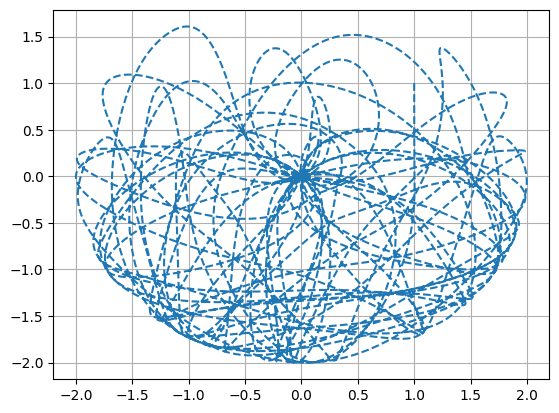

In [212]:
plt.plot(ball2[0], ball2[1], '--')
plt.grid()

MovieWriter ffmpeg unavailable; using Pillow instead.


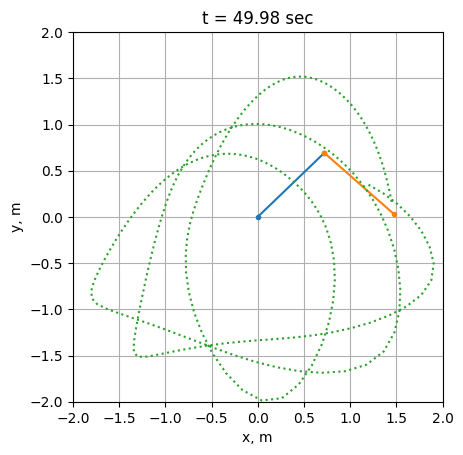

In [215]:
name = "dp_sim.gif"
sim.animate(t_vals[-1000:], y_traj_pol[:, -1000:], name)

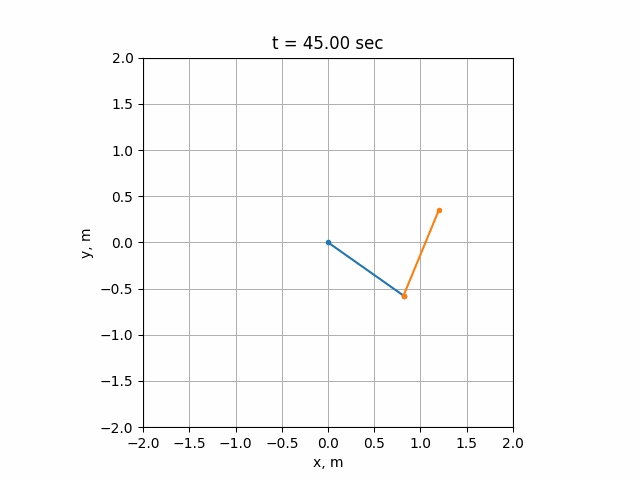

In [216]:
from IPython.display import Image

Image(name)

In [217]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [218]:
from itertools import pairwise


class DoublePendulumDataset(Dataset):
    def __init__(self, y_traj: torch.Tensor):
        self.xy_pairs = list(pairwise(y_traj))

    def __len__(self):
        return len(self.xy_pairs)

    def __getitem__(self, idx):
        return self.xy_pairs[idx]


class MLP(nn.Module):
    def __init__(self, hidden_size: int):
        super(MLP, self).__init__()
        seq = [
            nn.Linear(4, hidden_size),
            nn.ReLU(),
            # nn.Linear(hidden_size, hidden_size),
            # nn.ReLU(),
            nn.Linear(hidden_size, 4),
        ]
        self.fc = nn.Sequential(*seq)

    def forward(self, x):
        return self.fc(x)
    
    def size(self) -> int:
        return sum(p.numel() for p in self.parameters())

In [219]:
traj = torch.tensor(y_traj_pol, dtype=torch.float32)

In [220]:
n = int(traj.shape[1] * 0.8)
traj_train, traj_test = traj[:, :n], traj[:, n:]

In [221]:
train_loader = DataLoader(
    DoublePendulumDataset(traj_train.T),
    batch_size=50,
    shuffle=True,
)
test_loader = DataLoader(
    DoublePendulumDataset(traj_test.T),
    batch_size=50,
    shuffle=True,
)

In [222]:
def train(model, train_loader, test_loader, n_epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.98)
    criterion = nn.MSELoss()

    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            y_hat = model(x)
            train_loss = criterion(y_hat, y)
            train_loss.backward()
            optimizer.step()
        train_losses.append(train_loss.item())

        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                y_hat = model(x)
                loss = criterion(y_hat, y)
            print(f"Epoch {epoch}: {train_loss.item():.4f} {loss.item():.4f}")
            test_losses.append(loss.item())
        scheduler.step()
    return train_losses, test_losses

In [223]:
model = MLP(128)
print(model.size())

1156


In [224]:
train_hist, test_hist = train(model, train_loader, test_loader)

Epoch 0: 0.2296 0.4535
Epoch 1: 0.0496 0.1732
Epoch 2: 0.0367 0.0843
Epoch 3: 0.0192 0.0707
Epoch 4: 0.0165 0.0632
Epoch 5: 0.0117 0.1060
Epoch 6: 0.0145 0.0571
Epoch 7: 0.0142 0.0675
Epoch 8: 0.0120 0.0773
Epoch 9: 0.0140 0.0517
Epoch 10: 0.0127 0.0916
Epoch 11: 0.0127 0.0553
Epoch 12: 0.0094 0.0454
Epoch 13: 0.0095 0.0500
Epoch 14: 0.0085 0.0392
Epoch 15: 0.0087 0.0581
Epoch 16: 0.0072 0.0247
Epoch 17: 0.0073 0.0354
Epoch 18: 0.0099 0.0578
Epoch 19: 0.0090 0.0356
Epoch 20: 0.0110 0.0277
Epoch 21: 0.0079 0.0346
Epoch 22: 0.0085 0.0342
Epoch 23: 0.0066 0.0231
Epoch 24: 0.0096 0.0504
Epoch 25: 0.0086 0.0269
Epoch 26: 0.0090 0.0265
Epoch 27: 0.0054 0.0359
Epoch 28: 0.0063 0.0314
Epoch 29: 0.0068 0.0275
Epoch 30: 0.0044 0.0246
Epoch 31: 0.0091 0.0372
Epoch 32: 0.0065 0.0307
Epoch 33: 0.0071 0.0258
Epoch 34: 0.0042 0.0356
Epoch 35: 0.0060 0.0275
Epoch 36: 0.0089 0.0281
Epoch 37: 0.0042 0.0268
Epoch 38: 0.0067 0.0277
Epoch 39: 0.0094 0.0203
Epoch 40: 0.0050 0.0234
Epoch 41: 0.0055 0.0201
Ep

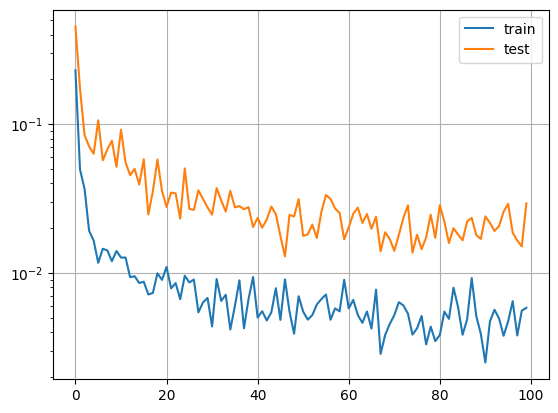

In [225]:
plt.plot(train_hist, label="train")
plt.plot(test_hist, label="test")
plt.grid()
plt.yscale("log")
plt.legend()
plt.show()

In [228]:
def evolve(model, y0, n_steps):
    y_traj = [y0]
    for _ in range(n_steps - 1):
        y_traj.append(model(y_traj[-1]))
    return torch.stack(y_traj).T

In [235]:
y0 = torch.tensor([np.pi / 2, np.pi, 0.0, 0.0])
y_traj_pred = evolve(model, y0, 200)

In [236]:
y_traj_pred_euc = sim.to_euclidean(y_traj_pred.detach().numpy())[0]

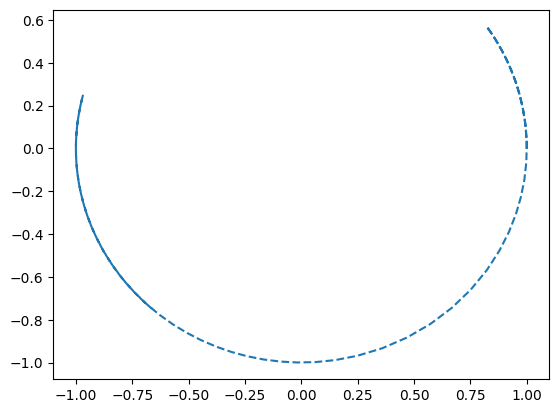

In [237]:
plt.plot(y_traj_pred_euc[0], y_traj_pred_euc[1], '--')